<h1>How do you define a drift in terms of depth?</h1>

<h2>When looking at a map of snow depth, it is all to easy to say 'we know drifts when we see them.'</h2>

<p>
However, this definition is unlikely to hold water with any earnest skeptic.
In this notebook I test how the areal fractions and the snow mass fractions of drift and not drift respond to changes in how we define drift by depth. To perform these tests I use the lidar snow depth dataset over Tuolumne.
</p>

In [1]:
import rasterio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import fiona
import pandas as pd
import seaborn as sns
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import Polygon
from scipy import stats
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
src =rasterio.open('/home/cparr/surfaces/depth_ddems/clpx/clpx_2017_dDEM_035m_offset.tif')
src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16384,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 397068.0,
       0.0, -1.0, 7624870.0),
 'width': 20480}

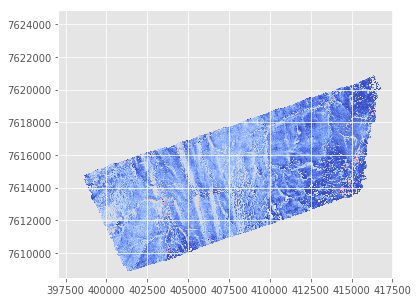

In [3]:
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(111)
im = show(src, cmap ='coolwarm',vmin=0,vmax=2)
ax.set_title('CLPX 2017 Snow Depth [m]')

In [4]:
def crop_and_test(src, center, size, title, thresh_type):
    
    '''
    This function is responsible for creating a subset of the full dataset and then testing
    different thresholds by masking out data at that threshold.
    The function returns a few plots and a DataFrame which stores the results.
    '''
    
    # Generate a square polygon to crop the full domain
    center_x = center[0]
    center_y = center[1]
    
    poly = Polygon([(center_x-(size / 2), center_y-(size / 2)),
           (center_x - (size / 2), center_y + (size / 2)),
           (center_x + (size / 2), center_y + (size / 2)),
           (center_x + (size / 2), center_y - (size / 2)),
           (center_x - (size / 2), center_y - (size / 2))])
    
    geom = [p for p in poly.boundary.coords]
    cropper = [{'coordinates': [geom],
              'type': 'Polygon'}]
    
    # Crop it and return the cropped data and affine transform
    out_image, out_transform = mask(src, cropper, crop=True)
    out_meta = src.meta.copy()
    
    # Calculate some stats
    mu = np.nanmean(out_image.data[0])
    sigma = np.nanstd(out_image.data[0])
    dmin = np.nanmin(out_image.data[0])
    dmax = np.nanmax(out_image.data[0])
    
    surface = out_image.data[0]
    surface = np.nan_to_num(surface)
    
    thresh_vals = []
    
    if thresh_type == 'max':
    
        # These are the precentage values of the max to test
        steps = [1,5,10,15,20,25,30,35,40,45,50,
                 55,60,65,70,75,80,85,90,95,99]
        xlab = '% of Max. Depth'
        
        for s in steps:
            thresh_vals.append((s / 100) * dmax)
        
    elif thresh_type == 'sigma':
        
        # Sigma multipliers added to the mean to test
        steps = [0,0.25,0.5,0.75,1,
                 1.25,1.5,1.75,2,
                 2.25,2.5,2.75,3]
        
        xlab = 'Sigma Above Mean'
        for s in steps:
            thresh_vals.append((s * sigma) + mu)
            
    # Initialize empty things to store results
    df = pd.DataFrame()
    
    drift_areas = []
    not_drift_areas = []
    drift_means = []
    not_drift_means = []
    drift_masses = []
    not_drift_masses = []
    drift_masses_pct = []
    not_drift_masses_pct = []
    area_check = []
    mass_check = []
    drifts_important = []
    thresh_m = []
    mass_area_deltas = []
    mass_area_ratios = []

    for threshold in thresh_vals:
        
        thresh_m.append(threshold)
        
        drift_mask = surface > threshold
        not_drift_mask = surface <= threshold
        
        drift_area = (drift_mask.sum() / surface.size) * 100
        not_drift_area = (not_drift_mask.sum() / surface.size) * 100

        drift_mean = (np.sum(drift_mask * surface)) / drift_mask.sum()
        not_drift_mean = (np.sum(not_drift_mask * surface)) / not_drift_mask.sum()

        drift_mass = drift_mean * drift_area
        not_drift_mass = not_drift_mean * not_drift_area
        
        drift_mass_pct = (drift_mass / (drift_mass + not_drift_mass)) * 100
        not_drift_mass_pct = 100 - drift_mass_pct

        mass_area_delta = drift_mass_pct - drift_area
        mass_area_ratio = drift_mass_pct / drift_area
        
        drift_areas.append(drift_area)
        not_drift_areas.append(not_drift_area)
        drift_means.append(drift_mean)
        not_drift_means.append(not_drift_mean)
        drift_masses.append(drift_mass)
        not_drift_masses.append(not_drift_mass)
        drift_masses_pct.append(drift_mass_pct)
        not_drift_masses_pct.append(not_drift_mass_pct)
        mass_area_deltas.append(mass_area_delta)
        mass_area_ratios.append(mass_area_ratio)
        
    for a, b in zip(drift_areas, not_drift_areas):
        area_check.append(a < b)
        
    for a, b in zip(drift_masses_pct, not_drift_masses_pct):
        mass_check.append(a > b)
        
    for a, b in zip(area_check, mass_check):
        drifts_important.append(a and b)
    
    drifts_important = drifts_important*1
    
    df['Threshold ' + '['+ xlab +']'] = steps
    df['Threshold [m]'] = thresh_m
    df['Drift Area [%]'] = drift_areas
    df['Not Drift Area [%]'] = not_drift_areas
    df['Drift Mean [m]'] = drift_means
    df['Not Drift Mean [m]'] = not_drift_means
    #df['Drift Mass'] = drift_masses
    #df['Not Drift Mass'] = not_drift_masses
    df['Drift Mass [%]'] = drift_masses_pct
    df['Not Drift Mass [%]'] = not_drift_masses_pct
    df['Are Drifts Dominant?'] = drifts_important
    df['Drift Mass-Area Delta [%]'] = mass_area_deltas
    df['Drift Mass:Area Ratio'] = mass_area_ratios
    
    # Generate Figures
    
    plt.figure(figsize = (16,10))
    ax=plt.subplot(111)
    plt.imshow(out_image.data[0], cmap='coolwarm', vmin = 0, vmax = dmax)
    ax.set_ylabel('m')
    ax.set_xlabel('m')
    plt.title(title +'\n'+ 
              "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma))
    plt.colorbar()
    
#     plt.figure(figsize=(8,5))
#     sns.distplot(out_image.data[0].flatten(), kde=False, norm_hist=True)
#     plt.xlabel('Depth [m]')
#     plt.ylabel('Empirical Probability')
    
    plt.figure(figsize=(8,5))
    plt.axhline(y=surface.mean(), color='g', alpha=0.5, label = 'Total Mean')
    plt.plot(steps, drift_means, '-ro', label = 'Drift Mean')
    plt.plot(steps, not_drift_means, '-bo', label = 'Not Drift Mean')
    plt.xlabel(xlab)
    plt.ylabel('Depth [m]')
    plt.legend()
    
    plt.figure(figsize=(8,5))
    plt.plot(steps, drift_areas, '-rx', label = 'Drift Area')
    plt.plot(steps, not_drift_areas, '-bx', label = 'Not Drift Area')
    plt.plot(steps, drift_masses_pct, '-ro', label = 'Drift Mass')
    plt.plot(steps, not_drift_masses_pct, '-bo', label = 'Not Drift Mass')
    plt.plot(steps, mass_area_deltas, '-g*', lw=3, label = 'Drift Mass - Drift Area Delta')
    plt.xlabel(xlab)
    plt.ylabel('%')
    plt.legend()

    return df.round(2)

<strong>For each test case there are 5 results:</strong>

<li> A table with all results. The 'Are Drifts Dominant?' column is populated by asking if the drift area is less than 50 % AND the drift mass is greater than 50 %.
<li> A 1 km x 1 km snow depth map in meters.
<li> A normalized histogram (pdf)
<li> A figure illustrating how the mean of the 'drift bucket' and 'not drift bucket' change in response to changing the threshold. The green line is the mean for the entire subset.
<li> A figure illustrating how the areal and mass fractions for drift and not drift change in response to changing the threshold. The green line is difference between the drift mass precentage and the drift area percentage.

Threshold [Sigma Above Mean]  Threshold [m]  Drift Area [%]  \
0                           0.00           0.56           46.38   
1                           0.25           0.61           36.70   
2                           0.50           0.67           28.37   
3                           0.75           0.73           21.56   
4                           1.00           0.78           16.12   
5                           1.25           0.84           11.78   
6                           1.50           0.89            8.18   
7                           1.75           0.95            5.45   
8                           2.00           1.01            3.40   
9                           2.25           1.06            1.96   
10                          2.50           1.12            1.07   
11                          2.75           1.17            0.57   
12                          3.00           1.23            0.31   

    Not Drift Area [%]  Drift Mean [m]  Not Drift Mean [m]  Drift Mass [%]  \
0                53.62            0.75                0.39           62.26   
1                63.30            0.79                0.42           52.10   
2                71.63            0.84                0.45           42.53   
3                78.44            0.88                0.47           34.03   
4                83.88            0.92                0.49           26.69   
5                88.22            0.97                0.50           20.39   
6                91.82            1.01                0.52           14.82   
7                94.55            1.06                0.53           10.31   
8                96.60            1.11                0.54            6.73   
9                98.04            1.16                0.55            4.06   
10               98.93            1.22                0.55            2.33   
11               99.43            1.29                0.55            1.31   
12               99.69            1.36                0.56            0.76   

    Not Drift Mass [%]  Are Drifts Dominant?  Drift Mass-Area Delta [%]  \
0                37.74                  True                      15.88   
1                47.90                  True                      15.40   
2                57.47                 False                      14.16   
3                65.97                 False                      12.47   
4                73.31                 False                      10.57   
5                79.61                 False                       8.62   
6                85.18                 False                       6.64   
7                89.69                 False                       4.86   
8                93.27                 False                       3.33   
9                95.94                 False                       2.10   
10               97.67                 False                       1.26   
11               98.69                 False                       0.74   
12               99.24                 False                       0.45   

    Drift Mass:Area Ratio  
0                    1.34  
1                    1.42  
2                    1.50  
3                    1.58  
4                    1.66  
5                    1.73  
6                    1.81  
7                    1.89  
8                    1.98  
9                    2.08  
10                   2.18  
11                   2.30  
12                   2.43

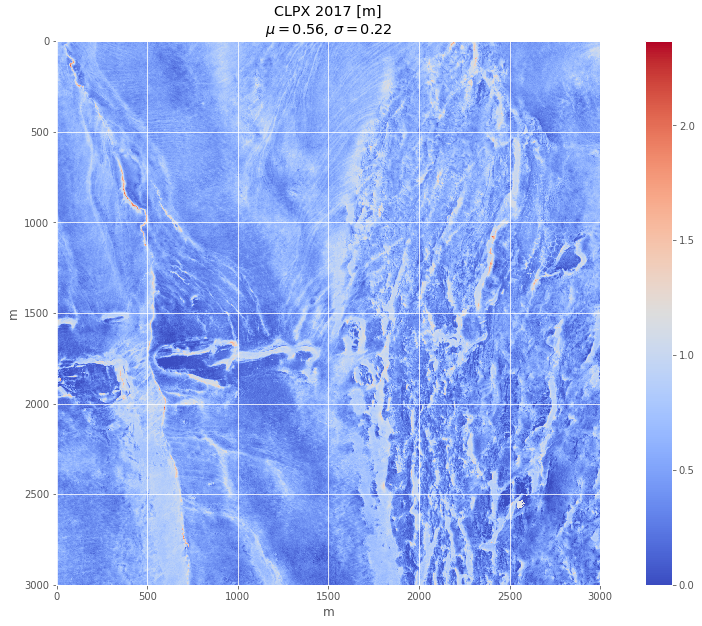

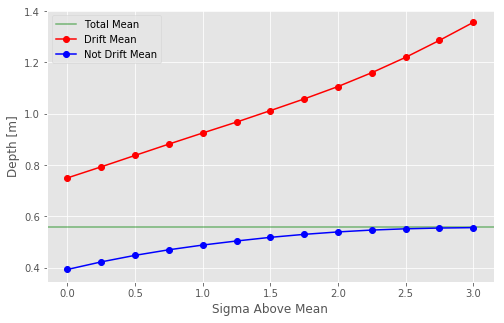

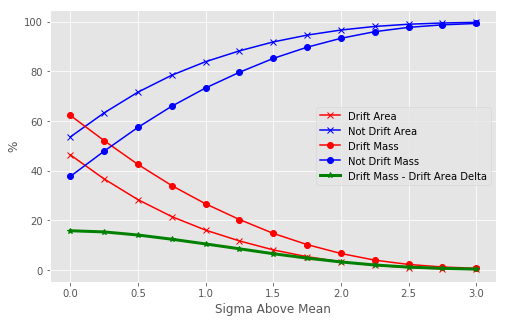

In [7]:
clpx_1 = (407500, 7614000)
clpx1 = crop_and_test(center=clpx_1,size=3000,src=src,title='CLPX 2017 [m]',thresh_type='sigma')
clpx1

Threshold [Sigma Above Mean]  Threshold [m]  Drift Area [%]  \
0                           0.00           0.33           43.19   
1                           0.25           0.38           33.30   
2                           0.50           0.44           24.92   
3                           0.75           0.49           18.42   
4                           1.00           0.55           13.78   
5                           1.25           0.61           10.55   
6                           1.50           0.66            8.20   
7                           1.75           0.72            6.40   
8                           2.00           0.77            4.95   
9                           2.25           0.83            3.70   
10                          2.50           0.88            2.59   
11                          2.75           0.94            1.70   
12                          3.00           0.99            1.05   

    Not Drift Area [%]  Drift Mean [m]  Not Drift Mean [m]  Drift Mass [%]  \
0                56.81            0.52                0.18           68.69   
1                66.70            0.57                0.21           57.98   
2                75.08            0.63                0.23           47.53   
3                81.58            0.69                0.25           38.34   
4                86.22            0.74                0.26           31.00   
5                89.45            0.79                0.28           25.37   
6                91.80            0.84                0.28           20.86   
7                93.60            0.88                0.29           17.12   
8                95.05            0.92                0.30           13.86   
9                96.30            0.96                0.31           10.82   
10               97.41            1.01                0.31            7.97   
11               98.30            1.07                0.32            5.51   
12               98.95            1.13                0.32            3.61   

    Not Drift Mass [%]  Are Drifts Dominant?  Drift Mass-Area Delta [%]  \
0                31.31                  True                      25.50   
1                42.02                  True                      24.68   
2                52.47                 False                      22.61   
3                61.66                 False                      19.92   
4                69.00                 False                      17.22   
5                74.63                 False                      14.81   
6                79.14                 False                      12.66   
7                82.88                 False                      10.72   
8                86.14                 False                       8.90   
9                89.18                 False                       7.12   
10               92.03                 False                       5.37   
11               94.49                 False                       3.81   
12               96.39                 False                       2.56   

    Drift Mass:Area Ratio  
0                    1.59  
1                    1.74  
2                    1.91  
3                    2.08  
4                    2.25  
5                    2.40  
6                    2.54  
7                    2.67  
8                    2.80  
9                    2.93  
10                   3.07  
11                   3.24  
12                   3.44

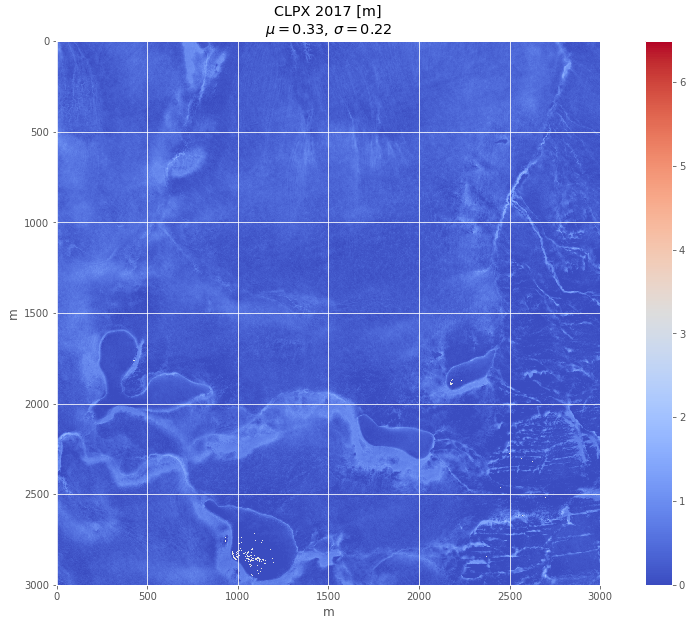

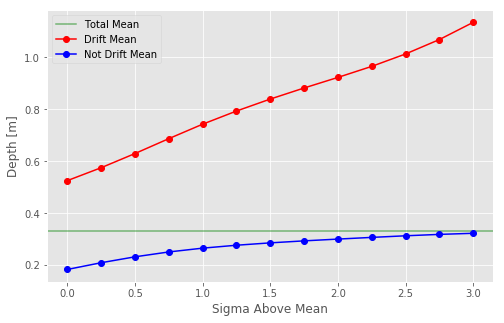

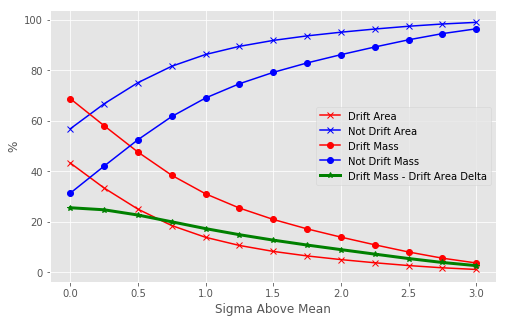

In [8]:
clpx_2 = (412500, 7616000)
clpx2 = crop_and_test(center=clpx_2,size=3000,src=src,title='CLPX 2017 [m]',thresh_type='sigma')
clpx2

Threshold [Sigma Above Mean]  Threshold [m]  Drift Area [%]  \
0                           0.00           0.32           39.57   
1                           0.25           0.37           28.77   
2                           0.50           0.43           20.71   
3                           0.75           0.48           15.10   
4                           1.00           0.54           11.38   
5                           1.25           0.59            8.89   
6                           1.50           0.65            7.16   
7                           1.75           0.70            5.86   
8                           2.00           0.76            4.85   
9                           2.25           0.81            4.05   
10                          2.50           0.86            3.35   
11                          2.75           0.92            2.73   
12                          3.00           0.97            2.18   

    Not Drift Area [%]  Drift Mean [m]  Not Drift Mean [m]  Drift Mass [%]  \
0                60.43            0.51                0.19           63.61   
1                71.23            0.58                0.22           51.92   
2                79.29            0.64                0.23           41.82   
3                84.90            0.71                0.25           33.84   
4                88.62            0.78                0.26           27.91   
5                91.11            0.84                0.27           23.53   
6                92.84            0.90                0.27           20.18   
7                94.14            0.95                0.28           17.43   
8                95.15            0.99                0.28           15.13   
9                95.95            1.04                0.29           13.15   
10               96.65            1.08                0.29           11.32   
11               97.27            1.12                0.30            9.60   
12               97.82            1.17                0.30            7.96   

    Not Drift Mass [%]  Are Drifts Dominant?  Drift Mass-Area Delta [%]  \
0                36.39                  True                      24.03   
1                48.08                  True                      23.14   
2                58.18                 False                      21.11   
3                66.16                 False                      18.74   
4                72.09                 False                      16.53   
5                76.47                 False                      14.64   
6                79.82                 False                      13.01   
7                82.57                 False                      11.57   
8                84.87                 False                      10.28   
9                86.85                 False                       9.11   
10               88.68                 False                       7.98   
11               90.40                 False                       6.87   
12               92.04                 False                       5.78   

    Drift Mass:Area Ratio  
0                    1.61  
1                    1.80  
2                    2.02  
3                    2.24  
4                    2.45  
5                    2.65  
6                    2.82  
7                    2.97  
8                    3.12  
9                    3.25  
10                   3.38  
11                   3.52  
12                   3.65

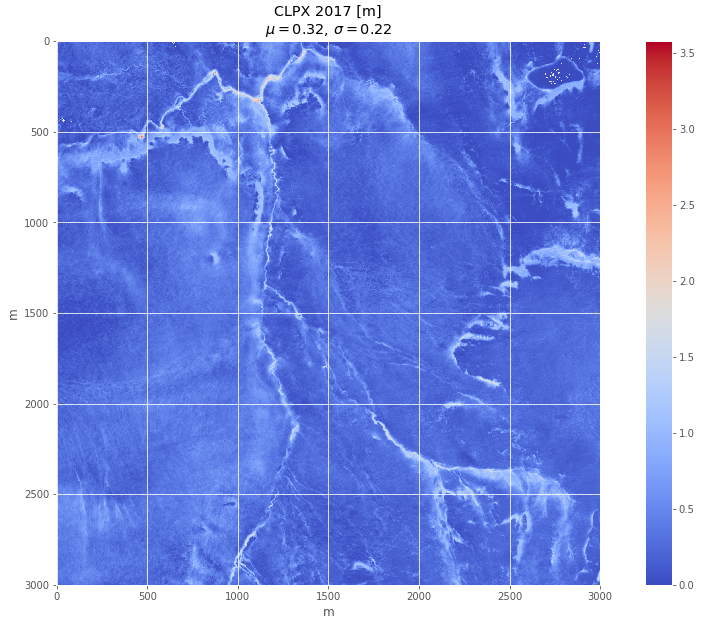

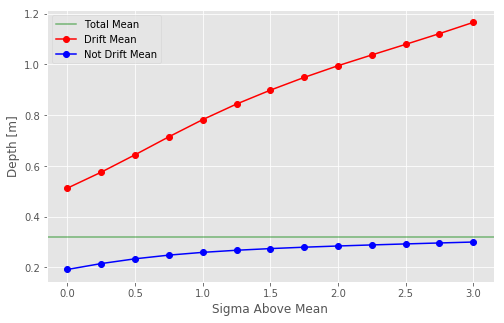

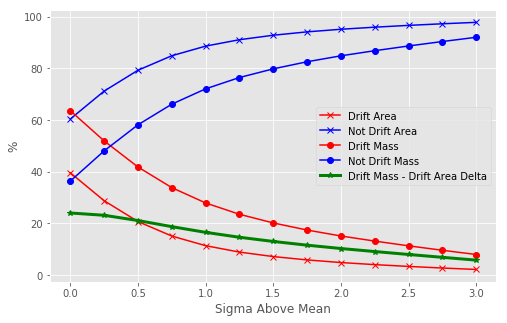

In [10]:
clpx_3 = (414000, 7618000)
clpx3 = crop_and_test(center=clpx_3,size=3000,src=src,title='CLPX 2017 [m]',thresh_type='sigma')
clpx3

Threshold [Sigma Above Mean]  Threshold [m]  Drift Area [%]  \
0                           0.00           0.57           44.89   
1                           0.25           0.62           33.27   
2                           0.50           0.67           24.03   
3                           0.75           0.72           17.46   
4                           1.00           0.78           12.93   
5                           1.25           0.83            9.70   
6                           1.50           0.88            7.28   
7                           1.75           0.94            5.38   
8                           2.00           0.99            3.87   
9                           2.25           1.04            2.75   
10                          2.50           1.09            1.95   
11                          2.75           1.15            1.39   
12                          3.00           1.20            1.03   

    Not Drift Area [%]  Drift Mean [m]  Not Drift Mean [m]  Drift Mass [%]  \
0                55.11            0.74                0.43           58.51   
1                66.73            0.79                0.46           46.36   
2                75.97            0.85                0.48           35.85   
3                82.54            0.90                0.50           27.78   
4                87.07            0.96                0.51           21.79   
5                90.30            1.01                0.52           17.22   
6                92.72            1.06                0.53           13.58   
7                94.62            1.11                0.54           10.53   
8                96.13            1.17                0.54            7.98   
9                97.25            1.23                0.55            5.96   
10               98.05            1.30                0.55            4.46   
11               98.61            1.37                0.56            3.37   
12               98.97            1.44                0.56            2.63   

    Not Drift Mass [%]  Are Drifts Dominant?  Drift Mass-Area Delta [%]  \
0                41.49                  True                      13.62   
1                53.64                 False                      13.09   
2                64.15                 False                      11.83   
3                72.22                 False                      10.32   
4                78.21                 False                       8.86   
5                82.78                 False                       7.52   
6                86.42                 False                       6.29   
7                89.47                 False                       5.15   
8                92.02                 False                       4.10   
9                94.04                 False                       3.22   
10               95.54                 False                       2.51   
11               96.63                 False                       1.97   
12               97.37                 False                       1.59   

    Drift Mass:Area Ratio  
0                    1.30  
1                    1.39  
2                    1.49  
3                    1.59  
4                    1.69  
5                    1.78  
6                    1.86  
7                    1.96  
8                    2.06  
9                    2.17  
10                   2.29  
11                   2.42  
12                   2.54

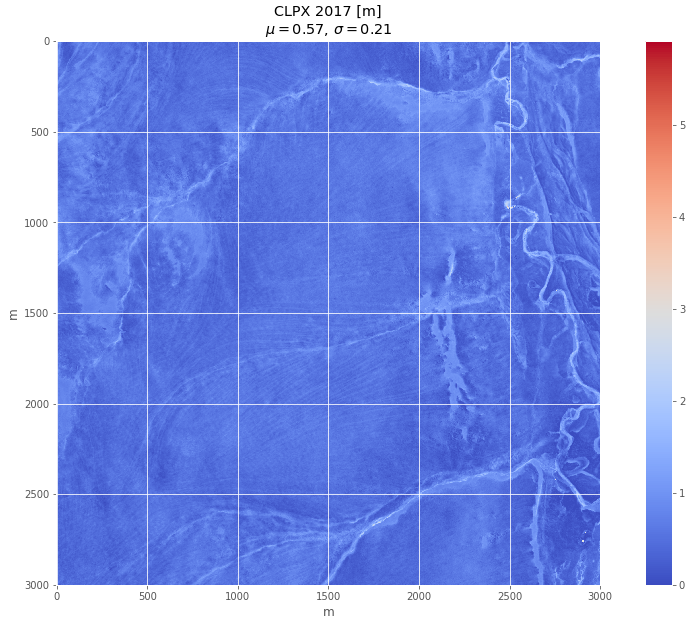

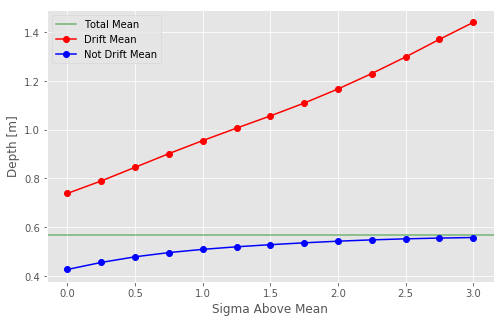

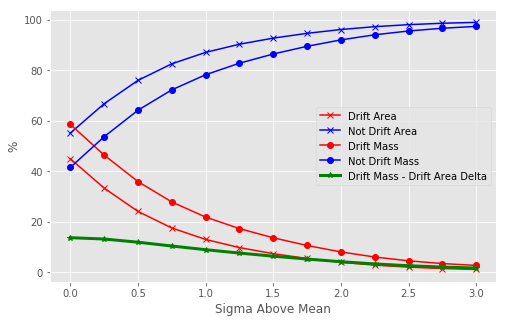

In [11]:
clpx_4 = (402500, 7612000)
clpx4 = crop_and_test(center=clpx_4,size=3000,src=src,title='CLPX 2017 [m]',thresh_type='sigma')
clpx4

Threshold [Sigma Above Mean]  Threshold [m]  Drift Area [%]  \
0                           0.00           0.27           35.16   
1                           0.25           0.34           26.50   
2                           0.50           0.41           20.73   
3                           0.75           0.48           16.60   
4                           1.00           0.55           13.48   
5                           1.25           0.62           11.10   
6                           1.50           0.70            9.13   
7                           1.75           0.77            7.35   
8                           2.00           0.84            5.65   
9                           2.25           0.91            4.14   
10                          2.50           0.98            3.01   
11                          2.75           1.05            2.23   
12                          3.00           1.12            1.69   

    Not Drift Area [%]  Drift Mean [m]  Not Drift Mean [m]  Drift Mass [%]  \
0                64.84            0.56                0.11           74.16   
1                73.50            0.64                0.13           64.35   
2                79.27            0.72                0.15           56.24   
3                83.40            0.79                0.16           49.32   
4                86.52            0.85                0.17           43.25   
5                88.90            0.91                0.18           37.97   
6                90.87            0.96                0.20           33.09   
7                92.65            1.02                0.21           28.17   
8                94.35            1.08                0.22           23.02   
9                95.86            1.16                0.23           18.05   
10               96.99            1.23                0.23           14.02   
11               97.77            1.31                0.24           11.02   
12               98.31            1.38                0.25            8.83   

    Not Drift Mass [%]  Are Drifts Dominant?  Drift Mass-Area Delta [%]  \
0                25.84                  True                      39.00   
1                35.65                  True                      37.84   
2                43.76                  True                      35.51   
3                50.68                 False                      32.72   
4                56.75                 False                      29.77   
5                62.03                 False                      26.87   
6                66.91                 False                      23.95   
7                71.83                 False                      20.82   
8                76.98                 False                      17.37   
9                81.95                 False                      13.91   
10               85.98                 False                      11.01   
11               88.98                 False                       8.79   
12               91.17                 False                       7.14   

    Drift Mass:Area Ratio  
0                    2.11  
1                    2.43  
2                    2.71  
3                    2.97  
4                    3.21  
5                    3.42  
6                    3.62  
7                    3.83  
8                    4.07  
9                    4.36  
10                   4.66  
11                   4.95  
12                   5.22

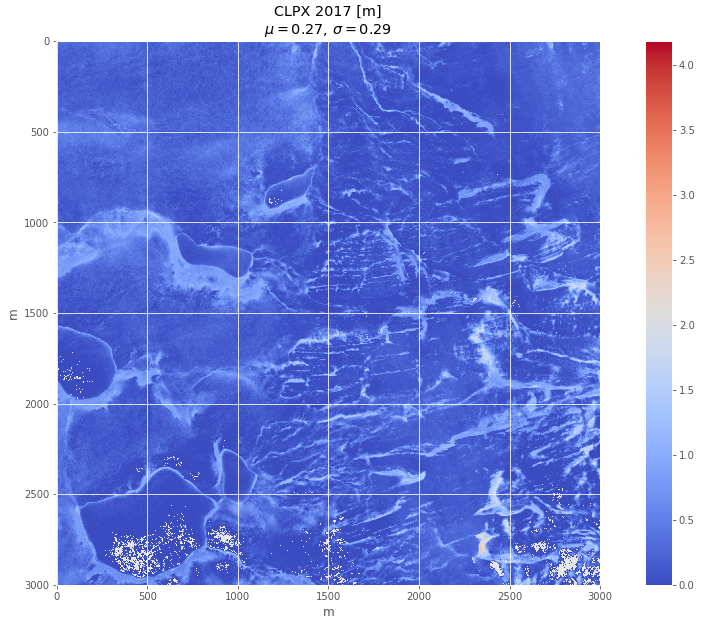

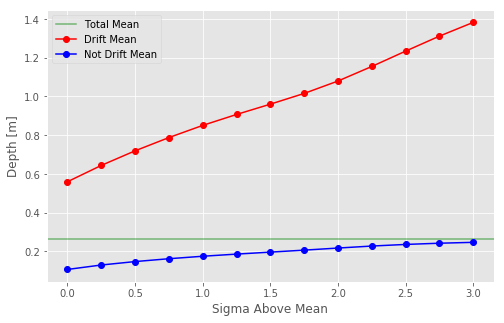

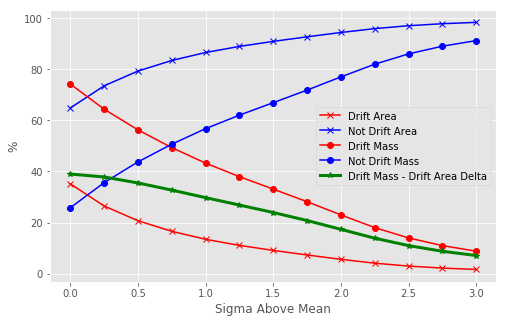

In [12]:
clpx_5 = (413500, 7615000)
clpx5 = crop_and_test(center=clpx_5,size=3000,src=src,title='CLPX 2017 [m]',thresh_type='sigma')
clpx5

In [13]:
# Combine all seven subsets and result tables

df_concat = pd.concat((clpx1, clpx2, clpx3, clpx4, clpx5))
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_means.round(2)

Threshold [Sigma Above Mean]  Threshold [m]  Drift Area [%]  \
0                           0.00           0.41           41.84   
1                           0.25           0.46           31.71   
2                           0.50           0.52           23.75   
3                           0.75           0.58           17.83   
4                           1.00           0.64           13.54   
5                           1.25           0.70           10.40   
6                           1.50           0.76            7.99   
7                           1.75           0.82            6.09   
8                           2.00           0.87            4.54   
9                           2.25           0.93            3.32   
10                          2.50           0.99            2.39   
11                          2.75           1.05            1.72   
12                          3.00           1.10            1.25   

    Not Drift Area [%]  Drift Mean [m]  Not Drift Mean [m]  Drift Mass [%]  \
0                58.16            0.62                0.26           65.45   
1                68.29            0.67                0.29           54.54   
2                76.25            0.74                0.31           44.79   
3                82.17            0.79                0.33           36.66   
4                86.46            0.85                0.34           30.13   
5                89.60            0.90                0.35           24.90   
6                92.01            0.95                0.36           20.51   
7                93.91            1.00                0.37           16.71   
8                95.46            1.05                0.38           13.34   
9                96.68            1.11                0.39           10.41   
10               97.61            1.17                0.39            8.02   
11               98.28            1.23                0.39            6.16   
12               98.75            1.30                0.40            4.76   

    Not Drift Mass [%]  Are Drifts Dominant?  Drift Mass-Area Delta [%]  \
0                34.55                   1.0                      23.61   
1                45.46                   0.8                      22.83   
2                55.21                   0.2                      21.04   
3                63.34                   0.0                      18.83   
4                69.87                   0.0                      16.59   
5                75.10                   0.0                      14.49   
6                79.49                   0.0                      12.51   
7                83.29                   0.0                      10.62   
8                86.66                   0.0                       8.80   
9                89.59                   0.0                       7.09   
10               91.98                   0.0                       5.63   
11               93.84                   0.0                       4.44   
12               95.24                   0.0                       3.50   

    Drift Mass:Area Ratio  
0                    1.59  
1                    1.76  
2                    1.93  
3                    2.09  
4                    2.25  
5                    2.40  
6                    2.53  
7                    2.66  
8                    2.81  
9                    2.96  
10                   3.12  
11                   3.29  
12                   3.46

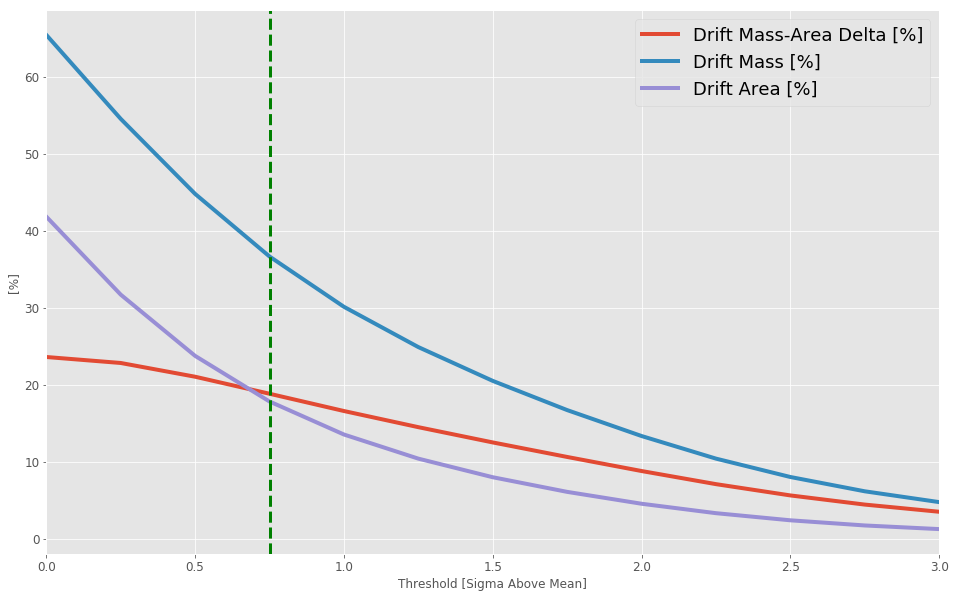

In [14]:
ax1 = df_means.plot(kind='line', x='Threshold [Sigma Above Mean]',
              y=['Drift Mass-Area Delta [%]','Drift Mass [%]', 'Drift Area [%]'],
              figsize=(16,10),
              xlim=(0,3), lw=4, fontsize=12)

ax1.legend(fontsize=18)
ax1.set_ylabel('[%]')

inflection = np.gradient(df_means['Drift Mass-Area Delta [%]']).argmin()
plt.axvline(df_means['Threshold [Sigma Above Mean]'][inflection], c='g', lw=3, ls='--')

In [15]:
df_means.iloc[3].round(2)

Threshold [Sigma Above Mean]     0.75
Threshold [m]                    0.58
Drift Area [%]                  17.83
Not Drift Area [%]              82.17
Drift Mean [m]                   0.79
Not Drift Mean [m]               0.33
Drift Mass [%]                  36.66
Not Drift Mass [%]              63.34
Are Drifts Dominant?             0.00
Drift Mass-Area Delta [%]       18.83
Drift Mass:Area Ratio            2.09
Name: 3, dtype: float64

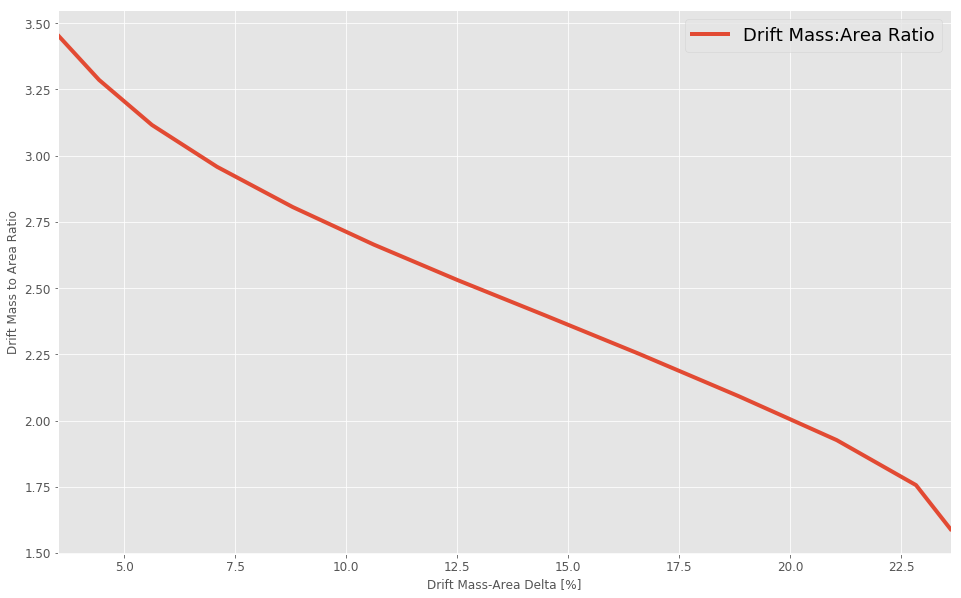

In [16]:
ax1 = df_means.sort_values('Drift Mass-Area Delta [%]').plot(kind='line', x='Drift Mass-Area Delta [%]',
              y='Drift Mass:Area Ratio',
              figsize=(16,10), lw=4, fontsize=12)

ax1.legend(fontsize=18)
ax1.set_ylabel('Drift Mass to Area Ratio')

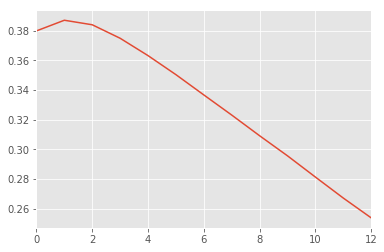

In [17]:
a = (df_means['Drift Area [%]'] / df_means['Not Drift Area [%]']) / (df_means['Drift Mass [%]'] / df_means['Not Drift Mass [%]'])
a.plot()